In [64]:
#qiskitQIMP\Scripts\activate.bat

import qiskit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as matpltimg

from skimage.transform import resize

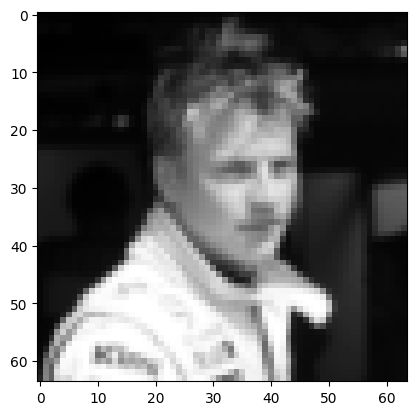

In [65]:
#Import + Processing
filename = 'kimi.jpg'
image = matpltimg.imread(filename)

# Resize the image
n_qubits = 12 # an even number, since image is square
n_pixels_per_side = 2**int(n_qubits/2)
image = resize(image, (n_pixels_per_side, n_pixels_per_side))

image = 0.299*image[:,:,0]+0.586*image[:,:,1]+0.144*image[:,:,2]

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
plt.show()

Statevector([0.00175728+0.j, 0.00180175+0.j, 0.00181664+0.j, ...,
             0.00246303+0.j, 0.00266647+0.j, 0.00290274+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
Statevector([ 2.51661094e-03+0.j, -3.14448828e-05+0.j,  2.52923561e-03+0.j,
             ..., -4.41457147e-05+0.j,  3.93802715e-03+0.j,
             -1.67064819e-04+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


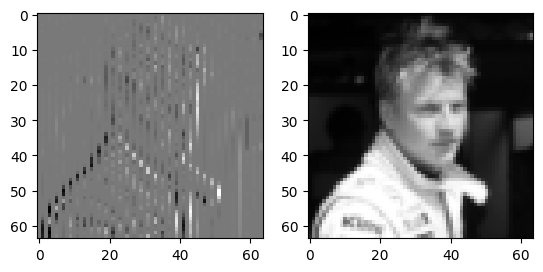

In [66]:
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import Initialize
from qiskit import QuantumCircuit

data = image.ravel()
data = data / np.linalg.norm(data)

# Create initializer
init_gate = Initialize(data)

# Build circuit
qc = QuantumCircuit(n_qubits)
qc.append(init_gate, qc.qubits)

state = Statevector.from_instruction(qc)  # qc = your QuantumCircuit
print(state)

qc_h = QuantumCircuit(n_qubits)     
qc_h.h(0)
new_state = state.evolve(qc_h)
print(new_state)


edge = np.real(new_state)

# Reshape into square image
n_rows = int(np.sqrt(len(edge)))
edge = edge.reshape(n_rows, n_rows)

# Zero out odd columns (keep only even columns where first qubit is 1)
edge[:, ::2] = 0

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(edge, cmap='gray')
ax[1].imshow(image, cmap='gray')  # im is the original image
plt.show()

In [67]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import Statevector
import numpy as np

# Normalize your data
data = data / np.linalg.norm(data)

# Compute number of qubits
n_qubits = int(np.log2(len(data)))

# Create initializer
init_gate = Initialize(data)

# Build circuit
qc = QuantumCircuit(n_qubits)
qc.append(init_gate, qc.qubits)
qc.draw('mpl')  # Use 'mpl' for better rendering in notebooks

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import Initialize
import numpy as np

# Assume `data` is already normalized and length is power of 2
n_qubits = int(np.log2(len(data)))

# Create circuit and initialize state
qc = QuantumCircuit(n_qubits)
init_gate = Initialize(data)
qc.append(init_gate, qc.qubits)

# Apply Hadamard to the first qubit
qc.h(0)

# Simulate
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, simulator).result()
final_state = result.get_statevector(qc)

# Convert complex amplitudes to real part for image
edge = np.real(final_state)

# Reshape into square image
n_rows = int(np.sqrt(len(edge)))
edge = edge.reshape(n_rows, n_rows)

# Zero out odd columns (keep only even columns where first qubit is 1)
edge[:, ::2] = 0

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(edge, cmap='gray')
ax[1].imshow(image, cmap='gray')  # im is the original image
plt.show()



ImportError: cannot import name 'Aer' from 'qiskit' (c:\Users\kenay_mk8uzd5\Desktop\qiskitQIMP\qiskitQIMP\Lib\site-packages\qiskit\__init__.py)

In [ ]:
import qiskit
print(qiskit.__version__)


2.0.0
